In [19]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
# svm
from sklearn.svm import SVC
# image descriptors
from skimage.feature import hog, local_binary_pattern, daisy, ORB, BRIEF, CENSURE
from skimage import io, color, exposure
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage import data
import skimage.feature
from sklearn.ensemble import RandomForestClassifier
# mlp
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve, validation_curve, StratifiedKFold, KFold
import io
from PIL import Image, ImageOps
import cv2
from sklearn.preprocessing import MinMaxScaler


# Loading stuff

In [20]:
dataset_dir = "D:\\Computer Science\\TCC Ciência e Tecnologia\\src\\others\\DogFaceNet\\dogfacenet_dataset"

images_dir = os.path.join(dataset_dir, "DogFaceNet_Dataset_224_1\\after_4_bis")

img_and_label_list = []

# every dir name is a label
for label in os.listdir(images_dir):
    label_dir = os.path.join(images_dir, label)
    for img in os.listdir(label_dir):
        img_and_label_list.append((os.path.join(label_dir, img), label))


df = pd.DataFrame(img_and_label_list, columns=["path", "label"])
pd.set_option('display.max_colwidth', None)
display(df)
df.to_csv("dogfacenet_dataset.csv", index=False)

,path,label
0,D:\Computer Science\TCC Ciência e Tecnologia\src\others\DogFaceNet\dogfacenet_dataset\DogFaceNet_Dataset_224_1\after_4_bis\0\0.0.jpg,0
1,D:\Computer Science\TCC Ciência e Tecnologia\src\others\DogFaceNet\dogfacenet_dataset\DogFaceNet_Dataset_224_1\after_4_bis\0\0.1.jpg,0
2,D:\Computer Science\TCC Ciência e Tecnologia\src\others\DogFaceNet\dogfacenet_dataset\DogFaceNet_Dataset_224_1\after_4_bis\0\0.2.jpg,0
3,D:\Computer Science\TCC Ciência e Tecnologia\src\others\DogFaceNet\dogfacenet_dataset\DogFaceNet_Dataset_224_1\after_4_bis\0\0.3.jpg,0
4,D:\Computer Science\TCC Ciência e Tecnologia\src\others\DogFaceNet\dogfacenet_dataset\DogFaceNet_Dataset_224_1\after_4_bis\0\0.4.jpg,0
...,...,...
8358,D:\Computer Science\TCC Ciência e Tecnologia\src\others\DogFaceNet\dogfacenet_dataset\DogFaceNet_Dataset_224_1\after_4_bis\999\999.1.jpg,999
8359,D:\Computer Science\TCC Ciência e Tecnologia\src\others\DogFaceNet\dogfacenet_dataset\DogFaceNet_Dataset_224_1\after_4_bis\999\999.2.jpg,999
8360,D:\Computer Science\TCC Ciência e Tecnologia\src\others\DogFaceNet\dogfacenet_dataset\DogFaceNet_Dataset_224_1\after_4_bis\999\999.3.jpg,999
8361,D:\Computer Science\TCC Ciência e Tecnologia\src\others\DogFaceNet\dogfacenet_dataset\DogFaceNet_Dataset_224_1\after_4_bis\999\999.4.jpg,999


# Spliting the dataset into train and test

In [21]:
#spliting dataset
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"])

In [22]:
from sklearn.base import BaseEstimator, TransformerMixin




class dataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformer):
        self.transformer = transformer

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.array([self.transformer(data) for data in X])

# Image preprocessing functions

In [23]:
def hog_descriptor(img):
    return hog(img)

def lbp_descriptor(img):
    return local_binary_pattern(img, P=8, R=1)

def daisy_descriptor(img):
    return daisy(img).flatten()

def orb_descriptor(img):
    orb = ORB(n_keypoints=200)
    orb.detect_and_extract(img)
    return orb.descriptors.flatten()

def brief_descriptor(img):
    brief = BRIEF()
    brief.extract(img)
    return brief.descriptors.flatten()

def censure_descriptor(img):
    censure = CENSURE()
    censure.detect(img)
    return censure.descriptors.flatten()

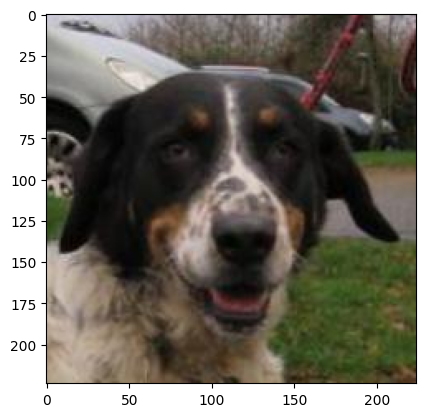

In [24]:
some_img_path = train_df["path"].iloc[0]
img = Image.open(some_img_path)
img = resize(np.array(img), (224, 224))


plt.imshow(img, cmap="gray")

In [25]:
def resize_img(img):
    return resize(img, (224, 224))

def rgb2gray_img(img):
    return rgb2gray(img)

def extract_patches(img):
    return extract_patches_2d(img, (8, 8))

In [26]:
def safe_imread(path):
    img = Image.open(path)
    if img is None:
        raise ValueError(f"Image couldn't be read from the path: {path}")
    return np.array(img)

In [27]:
def concat(data, *transformers, keep_original=True):
    if keep_original:
        return np.concatenate( [data.flatten()] + [transformer(data) for transformer in transformers])
    return np.concatenate([transformer(data) for transformer in transformers])

def flatten(data):
    return data.flatten()

In [28]:
pipeline = make_pipeline(
    dataTransformer(safe_imread),
    dataTransformer(resize_img),
)
X_train = pipeline.transform(train_df["path"])
X_test = pipeline.transform(test_df["path"])


# Feature extraction pipe

In [ ]:
# feat extraction pipeline
extract_pipe = make_pipeline(
    dataTransformer(rgb2gray_img),
    dataTransformer(extract_patches),
    lambda data: concat(data, hog_descriptor, lbp_descriptor, daisy_descriptor, orb_descriptor, brief_descriptor, censure_descriptor, keep_original=True, verbose=True)
)

# KNN

In [ ]:
# pipeline



pipeline2 = make_pipeline(
    dataTransformer(
    lambda data: concat(
        data,
        extract_pipe.transform,
    )),
    KNeighborsClassifier(n_neighbors=7)
)

pipeline2.fit(X_train, train_df["label"])


y_pred = pipeline2.predict(X_test)
print(classification_report(test_df["label"], y_pred))


NameError: name 'concat' is not defined

In [ ]:
print(y_pred == test_df["label"])

1054     True
2703    False
6393    False
4171    False
4246    False
        ...  
1517    False
2642    False
6833    False
6369    False
534     False
Name: label, Length: 1673, dtype: bool


In [ ]:
display(test_df)


,path,label
1054,D:\Computer Science\TCC Ciência e Tecnologia\src\others\DogFaceNet\dogfacenet_dataset\DogFaceNet_Dataset_224_1\after_4_bis\1188\1188.2.jpg,1188
2703,D:\Computer Science\TCC Ciência e Tecnologia\src\others\DogFaceNet\dogfacenet_dataset\DogFaceNet_Dataset_224_1\after_4_bis\17\17.3.jpg,17
6393,D:\Computer Science\TCC Ciência e Tecnologia\src\others\DogFaceNet\dogfacenet_dataset\DogFaceNet_Dataset_224_1\after_4_bis\620\620.1.jpg,620
4171,D:\Computer Science\TCC Ciência e Tecnologia\src\others\DogFaceNet\dogfacenet_dataset\DogFaceNet_Dataset_224_1\after_4_bis\336\336.4.jpg,336
4246,D:\Computer Science\TCC Ciência e Tecnologia\src\others\DogFaceNet\dogfacenet_dataset\DogFaceNet_Dataset_224_1\after_4_bis\347\347.0.jpg,347
...,...,...
1517,D:\Computer Science\TCC Ciência e Tecnologia\src\others\DogFaceNet\dogfacenet_dataset\DogFaceNet_Dataset_224_1\after_4_bis\1259\1259.4.jpg,1259
2642,D:\Computer Science\TCC Ciência e Tecnologia\src\others\DogFaceNet\dogfacenet_dataset\DogFaceNet_Dataset_224_1\after_4_bis\162\162.1.jpg,162
6833,D:\Computer Science\TCC Ciência e Tecnologia\src\others\DogFaceNet\dogfacenet_dataset\DogFaceNet_Dataset_224_1\after_4_bis\698\698.0.jpg,698
6369,D:\Computer Science\TCC Ciência e Tecnologia\src\others\DogFaceNet\dogfacenet_dataset\DogFaceNet_Dataset_224_1\after_4_bis\618\618.0.jpg,618
